In [17]:
import tensorflow as tf
from matplotlib import pyplot as plt

Load the pretrained MobileNetV2 model and the ImageNet class names

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [2]:
tf.keras.applications.mobilenet_v2.decode_predictions?

Signature: tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=5)
Docstring:
Decodes the prediction of an ImageNet model.

Args:
    preds: NumPy array encoding a batch of predictions.
    top: Integer, how many top-guesses to return. Defaults to `5`.

Returns:
    A list of lists of top class prediction tuples
    `(class_name, class_description, score)`.
    One list of tuples per sample in batch input.

Raises:
    ValueError: In case of invalid shape of the `pred` array
        (must be 2D).
File:      c:\users\shory\anaconda3\envs\myenv\lib\site-packages\keras\src\applications\mobilenet_v2.py
Type:      function

In [6]:
# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [7]:
# Preprocess the input image so that it can be used for mobilenet predictions
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Extract label from probability vector of dim = 1000
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [24]:
image_path = "images/fgsm-test-img/dog.jpeg"
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)
label = get_imagenet_label(image_probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


In [25]:
image

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.86507356, -0.90428925, -0.8590161 ],
         [-0.9217612 , -0.9636555 , -0.9429972 ],
         [-0.8792192 , -0.9307423 , -0.957528  ],
         ...,
         [-0.4700454 , -0.5037109 , -0.62473667],
         [-0.5106615 , -0.56288487, -0.6987041 ],
         [-0.59196275, -0.6468647 , -0.7880412 ]],

        [[-0.8769611 , -0.9155291 , -0.8822832 ],
         [-0.877767  , -0.91397154, -0.91038257],
         [-0.8052521 , -0.85432404, -0.88846326],
         ...,
         [-0.51390016, -0.5508044 , -0.6572119 ],
         [-0.54480016, -0.593277  , -0.7177167 ],
         [-0.6160176 , -0.67027164, -0.80006856]],

        [[-0.86530745, -0.8998603 , -0.88344467],
         [-0.80840474, -0.84245586, -0.85238254],
         [-0.70978   , -0.7579242 , -0.80636513],
         ...,
         [-0.5930667 , -0.6226883 , -0.720487  ],
         [-0.61302495, -0.6515753 , -0.75334316],
         [-0.6728864 , -0.7259265 , -0.8263758

In [26]:
image.shape

TensorShape([1, 224, 224, 3])

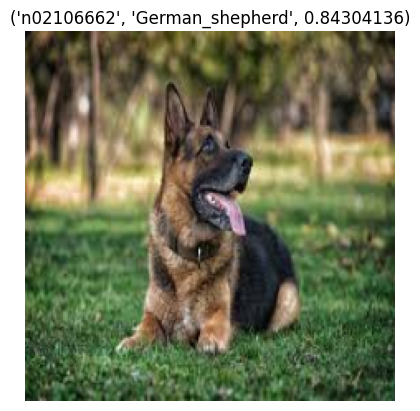

In [35]:
plt.imshow(image[0,:,:,:] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
plt.axis('off')
plt.title(get_imagenet_label(image_probs))
plt.show()

## Creating Adversarial Image

### Fast Gradient Sign Method (FGSM)

The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. For this, the gradients are taken with respect to the image. And trainabed weights are not used.

In [31]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

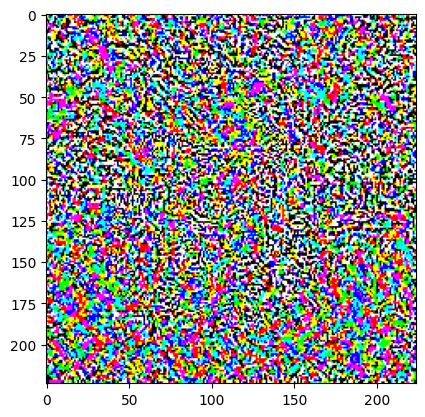

In [38]:
German_shepherd_label = 235 
label = tf.one_hot(German_shepherd_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0,:,:,:] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [39]:
def plot_image(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


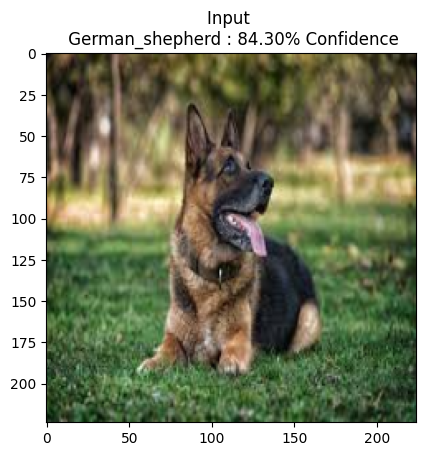

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


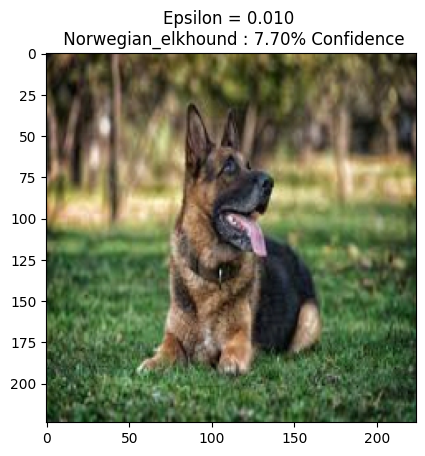

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


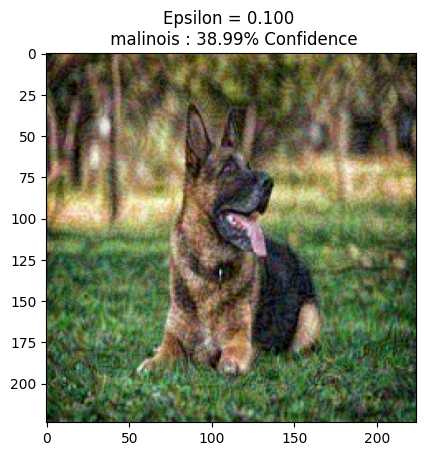

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


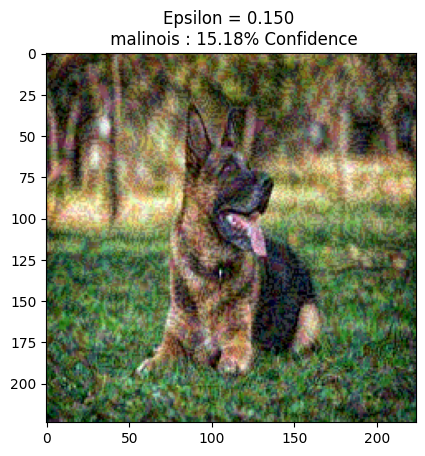

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


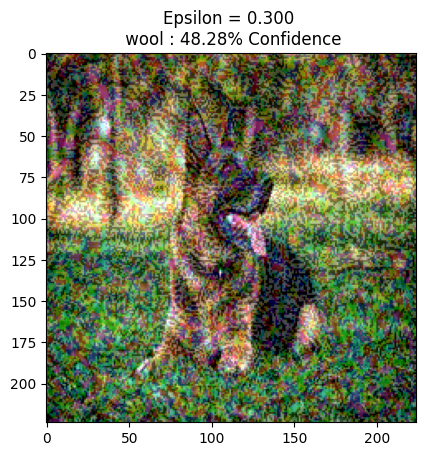

In [41]:
epsilons = [0, 0.01, 0.1, 0.15, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  plot_image(adv_x, descriptions[i])

As expected, as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.